In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.base import clone
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import pandas as pd
import math
import shap
import joblib

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?


In [3]:
from myflaml import auto_reg, auto_clf, auto_weighted_reg

In [4]:
time_budget = 5
stack = False
n_splits = 5
data = 'welfare'
plot = True

## For semi-synthetic data generation; available only if data='401k' 
semi_synth = False # True is available only if data='401k'
simple_synth = False # True is available only if data='401k'
max_depth = 3 # max depth for semi-synthetic model fitting
scale = .5

In [5]:
# The moment function, whose average we want to estimate: E[m(X; g)]
def moment_fn(x, test_fn):
    t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
    t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

In [6]:
def pehe(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

The Criteo dataset can be downloaded from here:
https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/input

The welfare dataset can be downloaded from here:
https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/ProcessedData/welfarenolabel3.csv

The 401k dataset can be downloaded from here:
https://github.com/stanford-msande228/winter23/401k

In [7]:
# Data loading and manipulation

if data == '401k':
    abtest = False
    def get_data(q=1, synthetic=False, random_seed=123, true_f=None, gen_epsilon=None):
        dfx = pd.read_csv('./401k/401k-x.csv', sep=',')
        dfy = pd.read_csv('./401k/401k-y.csv', sep=',')
        dfd = pd.read_csv('./401k/401k-d.csv', sep=',')
        dfx = dfx.drop(['db'], axis=1) # highly predictable from income
        X = np.hstack([dfd.values, dfx.values])
        column_names = ['treatment'] + list(dfx.columns)
        y = dfy.values.flatten() # outcome to numpy array

        mask = (dfx['inc'] > 0) & (dfx['inc'] >= np.percentile(dfx['inc'], 1))
        mask &= (dfx['inc'] <= np.percentile(dfx['inc'], 99))
        X = X[mask]
        y = y[mask]
        inds = np.arange(X.shape[0])
        np.random.shuffle(inds)
        X, y = X[inds], y[inds]

        if synthetic: # impute synthetic outcome based on known relationship  
            y = true_f(X) + gen_epsilon(X.shape[0])
            print(np.mean(moment_fn(X, true_f)))

        return X, y, [1, 2, 3, 4], column_names
elif data == 'criteo':
    abtest = True
    def get_data():
        df = pd.read_csv('./criteo-uplift-v2.1.csv')
        y = df['visit'].values
        T = df[['treatment']].values
        df = df.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
        column_names = ['treatment'] + list(df.columns)
        X = np.hstack([T, df.values])
        return X, y, np.arange(1, X.shape[1]), column_names
elif data == 'welfare':
    abtest = True
    def get_data():
        df = pd.read_csv('./welfarenolabel3.csv', na_values=-999)
        continuous = ['hrs1', 'income', 'rincome', 'age', 'polviews',
                      'educ', 'earnrs', 'sibs', 'childs', 'occ80', 'prestg80', 'indus80',
                      'res16', 'reg16', 'family16', 'parborn', 'maeduc', 'degree', 
                      'hompop', 'babies', 'preteen', 'teens', 'adults']
        categorical = ['partyid', 'wrkstat', 'wrkslf', 'marital', 'race', 'mobile16', 'sex', 'born']
        df = df[['y', 'w'] + continuous + categorical]
        df = df.dropna()
        df = df[~((df['polviews']>4) & (df['polviews'] < 5))]
        df = pd.get_dummies(df, columns=categorical, drop_first=True)
        display(df.describe())
        y = df['y'].values
        T = df[['w']].values
        df = df.drop(['y', 'w'], axis=1)
        column_names = ['treatment'] + list(df.columns)
        X = np.hstack([T, df.values])
        return X, y, np.arange(1, len(continuous) + 1), column_names

In [8]:
def true_f(X):
    return np.zeros(X.shape[0])

X, y, num_cols, column_names = get_data()
feat_ind = 2
print(column_names)

,y,w,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,...,marital_2.0,marital_3.0,marital_4.0,marital_5.0,race_2,race_3,mobile16_2.0,mobile16_3.0,sex_2,born_2.0
count,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,...,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000
mean,0.290850,0.513287,42.260324,11.305183,10.223367,40.573952,4.083443,14.026497,1.745177,3.426823,...,0.028512,0.164484,0.033083,0.245913,0.116526,0.063841,0.272178,0.337181,0.496242,0.087549
std,0.454172,0.499843,14.018162,1.635527,2.744435,12.179377,1.376485,2.722665,0.830837,2.918114,...,0.166436,0.370729,0.178860,0.430644,0.320867,0.244480,0.445098,0.472766,0.500005,0.282649
min,0.000000,0.000000,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,38.000000,12.000000,9.000000,31.000000,3.000000,12.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,40.000000,12.000000,12.000000,40.000000,4.000000,14.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,50.000000,12.000000,12.000000,49.000000,5.000000,16.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,89.000000,12.000000,12.000000,88.000000,7.000000,20.000000,8.000000,37.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


['treatment', 'hrs1', 'income', 'rincome', 'age', 'polviews', 'educ', 'earnrs', 'sibs', 'childs', 'occ80', 'prestg80', 'indus80', 'res16', 'reg16', 'family16', 'parborn', 'maeduc', 'degree', 'hompop', 'babies', 'preteen', 'teens', 'adults', 'partyid_1.0', 'partyid_2.0', 'partyid_3.0', 'partyid_4.0', 'partyid_5.0', 'partyid_6.0', 'partyid_7.0', 'wrkstat_2.0', 'wrkslf_2.0', 'marital_2.0', 'marital_3.0', 'marital_4.0', 'marital_5.0', 'race_2', 'race_3', 'mobile16_2.0', 'mobile16_3.0', 'sex_2', 'born_2.0']


In [9]:
# for semi-synthetic data generation; only for 401k dataset
if semi_synth:
    if simple_synth:
        def true_f(X):
            y = (-.7 - .4 * scipy.special.expit(3 * (1 - 2*(X[:, 2] - 30000)))) * X[:, 0]
            y += scipy.special.expit(3 * (1 - 2 * (X[:, 2] > 30000)))
            return y

        def gen_epsilon(n):
            scale = np.std(true_f(X))   
            return np.random.normal(0, .8 * scale, size=n)
    else:
        from sklearn.ensemble import RandomForestRegressor

        fitted_true_model = RandomForestRegressor(min_samples_leaf=50, max_depth=max_depth).fit(X, y)

        explainer = shap.KernelExplainer(lambda X: moment_fn(X, fitted_true_model.predict),
                                         X[np.random.choice(X.shape[0], 100)])
        shap_values = explainer.shap_values(X[:100], nsamples=100)
        shap.summary_plot(shap_values, feature_names=column_names)

        def true_f(X):
            return fitted_true_model.predict(X)

        true_residuals = y - cross_val_predict(clone(fitted_true_model), X, y, cv=5)
        def gen_epsilon(n):
            return scale * np.random.choice(true_residuals, size=n)

    X, y, num_cols, column_names = get_data(synthetic=True, true_f=true_f, gen_epsilon=gen_epsilon)

# Data Analysis

We now have our data X, y. The first column of X is the treatment and the rest are the control variables.

# Split Train and Validation

In [10]:
from sklearn.model_selection import train_test_split
X, Xval, y, yval = train_test_split(X, y, train_size=.6, shuffle=True)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, train_size=.5, shuffle=True)

# Nuisance Model Selection

In [11]:
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
splits = list(cv.split(X, X[:, 0]))

In [12]:
model_reg = auto_reg(X, y, n_splits=n_splits, verbose=3, time_budget=time_budget)
model_y = auto_reg(X[:, 1:], y, n_splits=n_splits, verbose=3, time_budget=time_budget)
model_t = auto_clf(X[:, 1:], X[:, 0], n_splits=n_splits, verbose=3, time_budget=time_budget)
model_reg_zero = auto_reg(X[X[:, 0]==0, 1:], y[X[:, 0]==0], n_splits=n_splits, verbose=3, time_budget=time_budget)
model_reg_one = auto_reg(X[X[:, 0]==1, 1:], y[X[:, 0]==1], n_splits=n_splits, verbose=3, time_budget=time_budget)

[flaml.automl.automl: 03-07 09:22:42] {2715} INFO - task = regression
[flaml.automl.automl: 03-07 09:22:42] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-07 09:22:42] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-07 09:22:42] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-07 09:22:42] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-07 09:22:42] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-07 09:22:42] {3460} INFO - Estimated sufficient time budget=1354s. Estimated necessary time budget=10s.
[flaml.automl.automl: 03-07 09:22:42] {3507} INFO -  at 0.2s,	estimator lgbm's best error=0.1857,	best estimator lgbm's best error=0.1857
[flaml.automl.automl: 03-07 09:22:42] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-07 09:22:42] {3507} INFO -  at 0.3s,	estimator lgbm's best error=0.1857,	best estimator

[flaml.automl.automl: 03-07 09:22:48] {3507} INFO -  at 1.0s,	estimator lgbm's best error=0.1990,	best estimator lgbm's best error=0.1990
[flaml.automl.automl: 03-07 09:22:48] {3322} INFO - iteration 7, current learner lgbm
[flaml.automl.automl: 03-07 09:22:49] {3507} INFO -  at 1.2s,	estimator lgbm's best error=0.1985,	best estimator lgbm's best error=0.1985
[flaml.automl.automl: 03-07 09:22:49] {3322} INFO - iteration 8, current learner lgbm
[flaml.automl.automl: 03-07 09:22:49] {3507} INFO -  at 1.3s,	estimator lgbm's best error=0.1985,	best estimator lgbm's best error=0.1985
[flaml.automl.automl: 03-07 09:22:49] {3322} INFO - iteration 9, current learner xgboost
[flaml.automl.automl: 03-07 09:22:49] {3507} INFO -  at 1.5s,	estimator xgboost's best error=0.2223,	best estimator lgbm's best error=0.1985
[flaml.automl.automl: 03-07 09:22:49] {3322} INFO - iteration 10, current learner xgboost
[flaml.automl.automl: 03-07 09:22:49] {3507} INFO -  at 1.7s,	estimator xgboost's best error=0

[flaml.automl.automl: 03-07 09:22:56] {3322} INFO - iteration 17, current learner extra_tree
[flaml.automl.automl: 03-07 09:22:57] {3507} INFO -  at 4.1s,	estimator extra_tree's best error=0.4862,	best estimator lgbm's best error=0.4833
[flaml.automl.automl: 03-07 09:22:57] {3322} INFO - iteration 18, current learner lgbm
[flaml.automl.automl: 03-07 09:22:57] {3507} INFO -  at 4.2s,	estimator lgbm's best error=0.4827,	best estimator lgbm's best error=0.4827
[flaml.automl.automl: 03-07 09:22:57] {3322} INFO - iteration 19, current learner xgboost
[flaml.automl.automl: 03-07 09:22:57] {3507} INFO -  at 4.4s,	estimator xgboost's best error=0.4889,	best estimator lgbm's best error=0.4827
[flaml.automl.automl: 03-07 09:22:57] {3322} INFO - iteration 20, current learner rf
[flaml.automl.automl: 03-07 09:22:57] {3507} INFO -  at 4.8s,	estimator rf's best error=0.4875,	best estimator lgbm's best error=0.4827
[flaml.automl.automl: 03-07 09:22:57] {3322} INFO - iteration 21, current learner xgbo

[flaml.automl.automl: 03-07 09:23:03] {3024} INFO - Time taken to find the best model: 3.4399781227111816
[flaml.automl.automl: 03-07 09:23:03] {2715} INFO - task = regression
[flaml.automl.automl: 03-07 09:23:03] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-07 09:23:03] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-07 09:23:03] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-07 09:23:03] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-07 09:23:03] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-07 09:23:03] {3460} INFO - Estimated sufficient time budget=805s. Estimated necessary time budget=6s.
[flaml.automl.automl: 03-07 09:23:03] {3507} INFO -  at 0.1s,	estimator lgbm's best error=0.1026,	best estimator lgbm's best error=0.1026
[flaml.automl.automl: 03-07 09:23:03] {3322} INFO - iteration 1, current learner lgbm
[flaml.a

In [13]:
model_reg()

AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x000002808DE1F640>)

In [14]:
model_y()

AutoMLWrap(model=<flaml.automl.model.ExtraTreesEstimator object at 0x000002808DE1F520>)

In [15]:
model_t()

AutoMLWrapCLF(model=<flaml.automl.model.LGBMEstimator object at 0x000002808DE1FDC0>)

In [16]:
# joblib.dump([model_reg(), model_y(), model_t(), model_reg_zero(), model_reg_one()], 'nuisance.jbl')

In [17]:
# mreg, my, mt, mreg_zero, mreg_one = joblib.load('nuisance.jbl')
# model_reg = lambda: clone(mreg)
# model_y = lambda: clone(my)
# model_t = lambda: clone(mt)
# model_reg_zero = lambda: clone(mreg_zero)
# model_reg_one = lambda: clone(mreg_one)

In [18]:
from sklearn.model_selection import cross_val_score
score_reg = np.mean(cross_val_score(model_reg(), X, y, cv=n_splits, scoring='r2'))
print(f'model_reg: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_y(), X[:, 1:], y, cv=n_splits, scoring='r2'))
print(f'model_y: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_t(), X[:, 1:], X[:, 0], cv=n_splits, scoring='r2'))
print(f'model_t: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_reg_zero(), X[X[:, 0]==0, 1:], y[X[:, 0]==0], cv=n_splits, scoring='r2'))
print(f'model_reg_zero: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_reg_one(), X[X[:, 0]==1, 1:], y[X[:, 0]==1], cv=n_splits, scoring='r2'))
print(f'model_reg_one: {score_reg:.3f}')

model_reg: 0.203
model_y: 0.042
model_t: -0.000
model_reg_zero: 0.069
model_reg_one: 0.031


# Nuisance Cross-Fitted Estimation and Prediction

In [19]:
from sklearn.model_selection import KFold, cross_val_predict

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X, X[:, 0]))

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg = model_reg().fit(X[train], y[train])
    reg_preds[test] = reg.predict(X[test])
    reg_one_preds[test] = reg.predict(np.hstack([np.ones((len(test), 1)), X[test, 1:]]))
    reg_zero_preds[test] = reg.predict(np.hstack([np.zeros((len(test), 1)), X[test, 1:]]))
    
    reg_zero = model_reg_zero().fit(X[train][X[train, 0]==0, 1:], y[train][X[train, 0]==0])
    reg_one = model_reg_one().fit(X[train][X[train, 0]==1, 1:], y[train][X[train, 0]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X[test, 1:])
    reg_one_preds_t[test] = reg_one.predict(X[test, 1:])

res_preds = cross_val_predict(model_y(), X[:, 1:], y, cv=splits)
prop_preds = cross_val_predict(model_t(), X[:, 1:], X[:, 0], cv=splits)

# CATE Model Estimation

In [20]:
hetero_inds = np.arange(1, X.shape[1])

In [22]:
model_final_fn = lambda X, y: auto_reg(X, y, n_splits=n_splits, verbose=3, time_budget=time_budget)

In [23]:
# slearner
slearner_best = model_final_fn(X[:, hetero_inds], reg_one_preds - reg_zero_preds)
slearner = slearner_best().fit(X[:, hetero_inds], reg_one_preds - reg_zero_preds)
slearner_preds = slearner.predict(X[:, hetero_inds])

[flaml.automl.automl: 03-07 09:36:47] {2715} INFO - task = regression
[flaml.automl.automl: 03-07 09:36:47] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-07 09:36:47] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-07 09:36:47] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-07 09:36:47] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-07 09:36:47] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-07 09:36:47] {3460} INFO - Estimated sufficient time budget=1281s. Estimated necessary time budget=9s.
[flaml.automl.automl: 03-07 09:36:47] {3507} INFO -  at 0.2s,	estimator lgbm's best error=0.0099,	best estimator lgbm's best error=0.0099
[flaml.automl.automl: 03-07 09:36:47] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-07 09:36:47] {3507} INFO -  at 0.3s,	estimator lgbm's best error=0.0099,	best estimator 

In [24]:
# tlearner
tlearner_best = model_final_fn(X[:, hetero_inds], reg_one_preds_t - reg_zero_preds_t)
tlearner = tlearner_best().fit(X[:, hetero_inds], reg_one_preds_t - reg_zero_preds_t)
tlearner_preds = tlearner.predict(X[:, hetero_inds])

[flaml.automl.automl: 03-07 09:36:59] {2715} INFO - task = regression
[flaml.automl.automl: 03-07 09:36:59] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-07 09:36:59] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-07 09:36:59] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-07 09:36:59] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-07 09:36:59] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-07 09:36:59] {3460} INFO - Estimated sufficient time budget=1803s. Estimated necessary time budget=13s.
[flaml.automl.automl: 03-07 09:36:59] {3507} INFO -  at 0.2s,	estimator lgbm's best error=0.0079,	best estimator lgbm's best error=0.0079
[flaml.automl.automl: 03-07 09:36:59] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-07 09:36:59] {3507} INFO -  at 0.3s,	estimator lgbm's best error=0.0079,	best estimator

In [94]:
# xlearner
tau1_preds = y[X[:, 0]==1] - reg_zero_preds_t[X[:, 0]==1]
tau0_preds = reg_one_preds_t[X[:, 0]==0] - y[X[:, 0]==0]
tau1 = model_final_fn(X[X[:, 0]==1][:, 1:], tau1_preds)().fit(X[X[:, 0]==1][:, 1:], tau1_preds)
tau0 = model_final_fn(X[X[:, 0]==0][:, 1:], tau0_preds)().fit(X[X[:, 0]==0][:, 1:], tau0_preds)
xtarget = prop_preds * tau0.predict(X[:, 1:]) + (1 - prop_preds) * tau1.predict(X[:, 1:])
xlearner = model_final_fn(X[:, hetero_inds], xtarget)().fit(X[:, hetero_inds], xtarget)
xlearner_preds = xlearner.predict(X[:, hetero_inds])

[flaml.automl.automl: 03-07 10:58:46] {2715} INFO - task = regression
[flaml.automl.automl: 03-07 10:58:46] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-07 10:58:46] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-07 10:58:46] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-07 10:58:46] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-07 10:58:46] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-07 10:58:47] {3460} INFO - Estimated sufficient time budget=1611s. Estimated necessary time budget=11s.
[flaml.automl.automl: 03-07 10:58:47] {3507} INFO -  at 0.2s,	estimator lgbm's best error=0.1052,	best estimator lgbm's best error=0.1052
[flaml.automl.automl: 03-07 10:58:47] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-07 10:58:47] {3507} INFO -  at 0.3s,	estimator lgbm's best error=0.1052,	best estimator

[flaml.automl.automl: 03-07 10:58:53] {3322} INFO - iteration 9, current learner lgbm
[flaml.automl.automl: 03-07 10:58:53] {3507} INFO -  at 1.2s,	estimator lgbm's best error=0.2330,	best estimator lgbm's best error=0.2330
[flaml.automl.automl: 03-07 10:58:53] {3322} INFO - iteration 10, current learner xgboost
[flaml.automl.automl: 03-07 10:58:53] {3507} INFO -  at 1.3s,	estimator xgboost's best error=0.5567,	best estimator lgbm's best error=0.2330
[flaml.automl.automl: 03-07 10:58:53] {3322} INFO - iteration 11, current learner extra_tree
[flaml.automl.automl: 03-07 10:58:53] {3507} INFO -  at 1.6s,	estimator extra_tree's best error=0.2336,	best estimator lgbm's best error=0.2330
[flaml.automl.automl: 03-07 10:58:53] {3322} INFO - iteration 12, current learner rf
[flaml.automl.automl: 03-07 10:58:54] {3507} INFO -  at 2.0s,	estimator rf's best error=0.2358,	best estimator lgbm's best error=0.2330
[flaml.automl.automl: 03-07 10:58:54] {3322} INFO - iteration 13, current learner xgboo

[flaml.automl.automl: 03-07 10:59:02] {3771} INFO - retrain lgbm for 0.0s
[flaml.automl.automl: 03-07 10:59:02] {3778} INFO - retrained model: LGBMRegressor(colsample_bytree=0.8304072431299575,
              learning_rate=0.7590459488450945, max_bin=255,
              min_child_samples=5, n_estimators=11, num_leaves=5,
              reg_alpha=0.001951378031519758, reg_lambda=0.04792552866398477,
              verbose=-1)
[flaml.automl.automl: 03-07 10:59:02] {3023} INFO - fit succeeded
[flaml.automl.automl: 03-07 10:59:02] {3024} INFO - Time taken to find the best model: 1.2485780715942383


In [26]:
# drlearner
dr_preds = reg_one_preds - reg_zero_preds
dr_preds += (y - reg_preds) * (X[:, 0] - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
drlearner_best = model_final_fn(X[:, hetero_inds], dr_preds)
drlearner = drlearner_best().fit(X[:, hetero_inds], dr_preds)
drlearner_preds = drlearner.predict(X[:, hetero_inds])

[flaml.automl.automl: 03-07 09:54:57] {2715} INFO - task = regression
[flaml.automl.automl: 03-07 09:54:57] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-07 09:54:57] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-07 09:54:57] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-07 09:54:57] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-07 09:54:57] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-07 09:54:57] {3460} INFO - Estimated sufficient time budget=1265s. Estimated necessary time budget=9s.
[flaml.automl.automl: 03-07 09:54:57] {3507} INFO -  at 0.1s,	estimator lgbm's best error=0.6819,	best estimator lgbm's best error=0.6819
[flaml.automl.automl: 03-07 09:54:57] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-07 09:54:57] {3507} INFO -  at 0.3s,	estimator lgbm's best error=0.6819,	best estimator 

In [28]:
# rlearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from econml.sklearn_extensions.linear_model import WeightedLassoCV

yres = y - res_preds
tres = X[:, 0] - prop_preds
tres = np.clip(tres, .001, np.inf) * (tres >= 0) + np.clip(tres, -np.inf, -.001) * (tres < 0)

rlearner_fn = auto_weighted_reg(X[:, hetero_inds], yres / tres, sample_weight=tres**2)
rlearner_rf = rlearner_fn().fit(X[:, hetero_inds], yres / tres, sample_weight=tres**2)

rlearner_preds_rf = rlearner_rf.predict(X[:, hetero_inds])

# Causal Score Estimation and Definition

In [29]:
splits_val = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(Xval, Xval[:, 0]))

n = Xval.shape[0]
reg_preds_val = np.zeros(n)
reg_zero_preds_val = np.zeros(n)
reg_one_preds_val = np.zeros(n)

for train, test in splits_val:
    reg_val = model_reg().fit(Xval[train], yval[train])
    reg_preds_val[test] = reg_val.predict(Xval[test])
    reg_one_preds_val[test] = reg_val.predict(np.hstack([np.ones((len(test), 1)), Xval[test, 1:]]))
    reg_zero_preds_val[test] = reg_val.predict(np.hstack([np.zeros((len(test), 1)), Xval[test, 1:]]))

res_preds_val = cross_val_predict(model_y(), Xval[:, 1:], yval, cv=splits_val)
prop_preds_val = cross_val_predict(model_t(), Xval[:, 1:], Xval[:, 0], cv=splits_val)
yres_val = yval - res_preds_val
tres_val = Xval[:, 0] - prop_preds_val

In [30]:
dr_val = reg_one_preds_val - reg_zero_preds_val
reisz_val = (Xval[:, 0] - prop_preds_val) / np.clip(prop_preds_val * (1 - prop_preds_val), .09, np.inf)
dr_val += (yval - reg_preds_val) * reisz_val

In [31]:
overall_ate_val_r = np.mean(yres_val * tres_val) / np.mean(tres_val**2)
def rscore(cate_preds): 
    rscore_t = np.mean((yres_val - cate_preds * tres_val)**2)
    rscore_b = np.mean((yres_val - overall_ate_val_r * tres_val)**2)
    return 1 - rscore_t / rscore_b

overall_ate_val_dr = np.mean(dr_val)
def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return 1 - drscore_t / drscore_b

# Score CATE Models

In [33]:
slearner_rscore = rscore(slearner.predict(Xval[:, hetero_inds]))
slearner_drscore = drscore(slearner.predict(Xval[:, hetero_inds]))
print(slearner_rscore, slearner_drscore)

0.002317852229137718 0.0013461989449101708


In [34]:
tlearner_rscore = rscore(tlearner.predict(Xval[:, hetero_inds]))
tlearner_drscore = drscore(tlearner.predict(Xval[:, hetero_inds]))
print(tlearner_rscore, tlearner_drscore)

0.002104262841753024 0.0017060830576356434


In [35]:
xlearner_rscore = rscore(xlearner.predict(Xval[:, hetero_inds]))
xlearner_drscore = drscore(xlearner.predict(Xval[:, hetero_inds]))
print(xlearner_rscore, xlearner_drscore)

0.0002845480231584707 0.00038488474071629586


In [36]:
drlearner_rscore = rscore(drlearner.predict(Xval[:, hetero_inds]))
drlearner_drscore = drscore(drlearner.predict(Xval[:, hetero_inds]))
print(drlearner_rscore, drlearner_drscore)

0.0031008856319981737 0.001688761230987712


In [37]:
rlearner_rf_rscore = rscore(rlearner_rf.predict(Xval[:, hetero_inds]))
rlearner_rf_drscore = drscore(rlearner_rf.predict(Xval[:, hetero_inds]))
print(rlearner_rf_rscore, rlearner_rf_drscore)

0.0013992313435154946 -0.0005114990345229664


# Plotting CATE

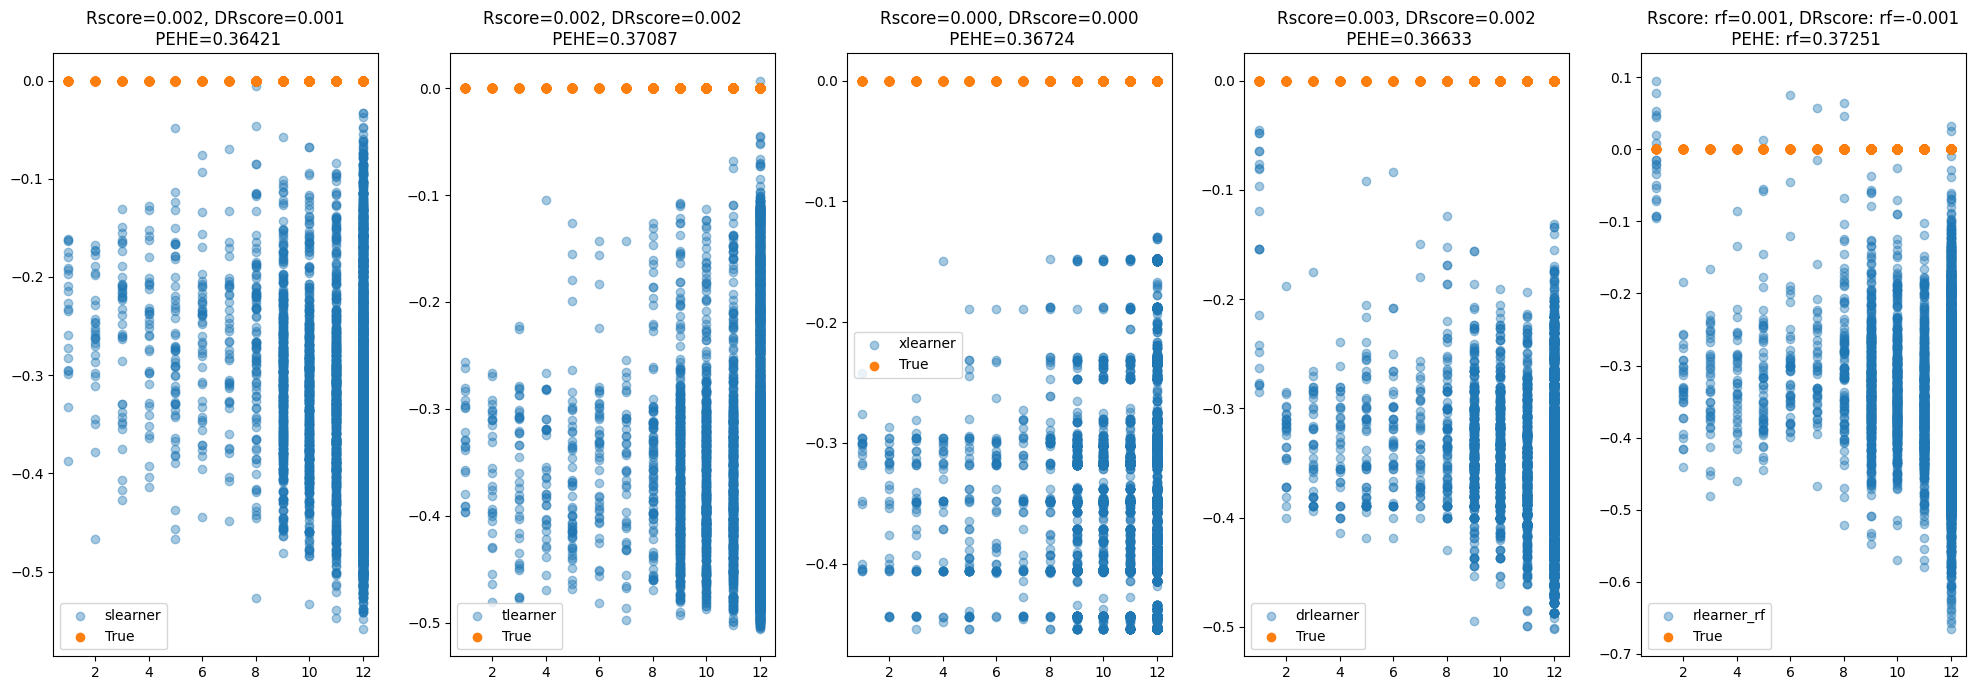

In [39]:
if plot:
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 5, 1)
    plt.scatter(X[:, feat_ind], slearner_preds, label='slearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={slearner_rscore:.3f}, DRscore={slearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), slearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.scatter(X[:, feat_ind], tlearner_preds, label='tlearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={tlearner_rscore:.3f}, DRscore={tlearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), tlearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.scatter(X[:, feat_ind], xlearner_preds, label='xlearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={xlearner_rscore:.3f}, DRscore={xlearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), xlearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 4)
    plt.scatter(X[:, feat_ind], drlearner_preds, label='drlearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={drlearner_rscore:.3f}, DRscore={drlearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), drlearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 5)
    plt.scatter(X[:, feat_ind], rlearner_preds_rf, label='rlearner_rf', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore: rf={rlearner_rf_rscore:.3f}, '
              f'DRscore: rf={rlearner_rf_drscore:.3f}\n '
              f'PEHE: rf={pehe(moment_fn(X, true_f), rlearner_preds_rf):.5f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Causal Model Selection and Ensembling

In [40]:
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
    
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
    
    def predict(self, X):
        return np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)

In [48]:
models = [slearner, tlearner, xlearner, drlearner, rlearner_rf]
scores = np.array([slearner_rscore, tlearner_rscore, xlearner_rscore, drlearner_rscore,
                   rlearner_rf_rscore])

eta_grid = np.logspace(-3, 4, 5)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * scores)
    ensemble = Ensemble(models, weights)
    ens[eta] = (ensemble, rscore(ensemble.predict(Xval[:, hetero_inds])))

rscore_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= rscore_best:
        rscore_best = ens[eta][1]
        eta_best = eta

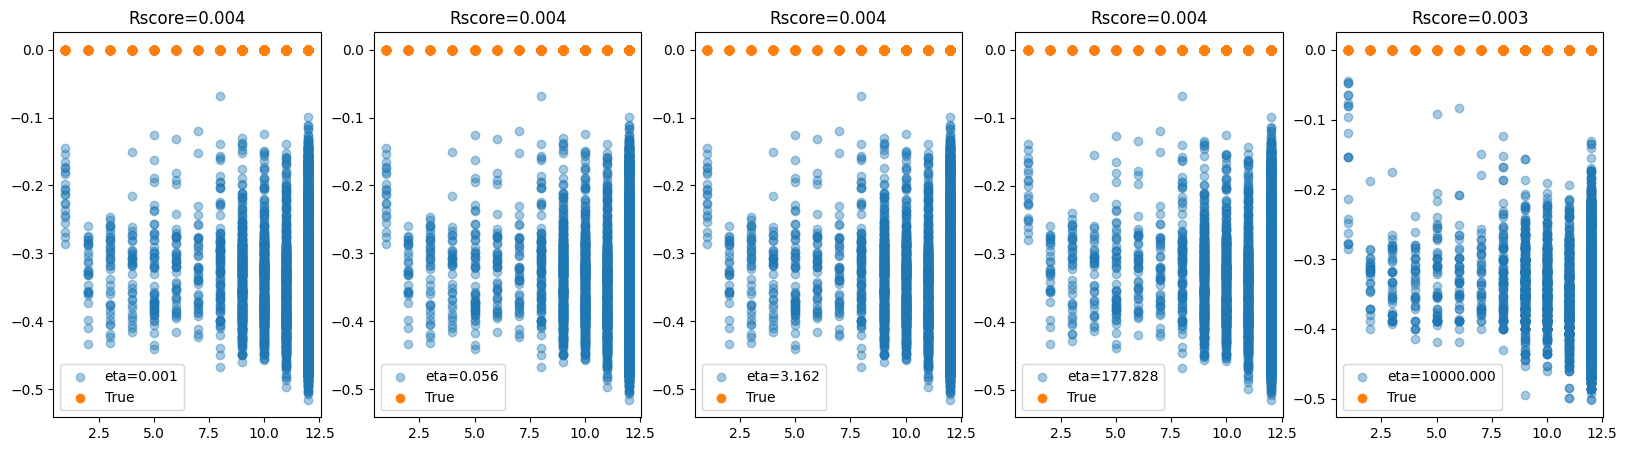

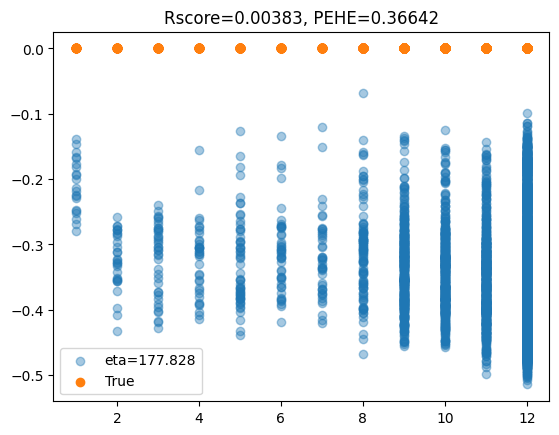

In [49]:
if plot:
    plt.figure(figsize=(20, 5))
    for it, eta in enumerate(eta_grid):
        plt.subplot(1, len(eta_grid), it + 1)
        plt.scatter(X[:, feat_ind], ens[eta][0].predict(X[:, hetero_inds]), label=f'eta={eta:.3f}', alpha=.4)
        plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
        plt.title(f'Rscore={ens[eta][1]:.3f}')
        plt.legend()
    plt.show()

    plt.scatter(X[:, feat_ind], ens[eta_best][0].predict(X[:, hetero_inds]), label=f'eta={eta_best:.3f}', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={ens[eta_best][1]:.5f}, '
              f'PEHE={pehe(moment_fn(X, true_f), ens[eta_best][0].predict(X[:, hetero_inds])):.5f}')
    plt.legend()
    plt.show()

In [50]:
rscore_best = ens[eta_best]

In [51]:
models = [slearner, tlearner, xlearner, drlearner, rlearner_rf]
scores = np.array([slearner_drscore, tlearner_drscore, xlearner_drscore, drlearner_drscore,
                   rlearner_rf_drscore])

eta_grid = np.logspace(-3, 4, 5)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * scores)
    ensemble = Ensemble(models, weights)
    ens[eta] = (ensemble, drscore(ensemble.predict(Xval[:, hetero_inds])))

drscore_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= drscore_best:
        drscore_best = ens[eta][1]
        eta_best = eta

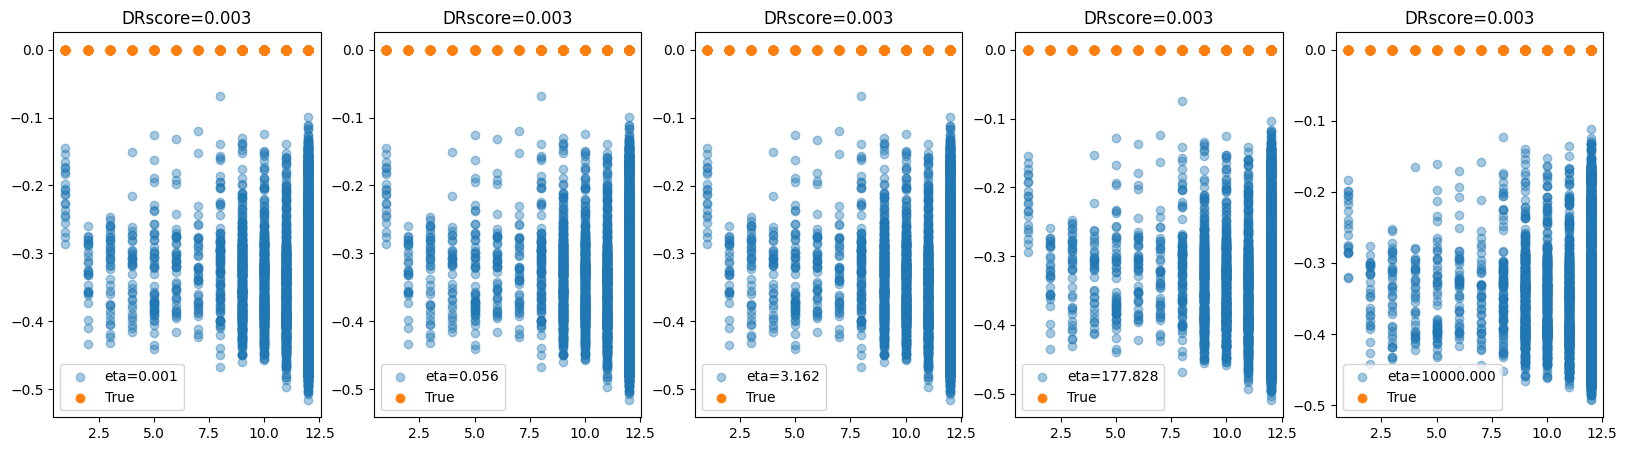

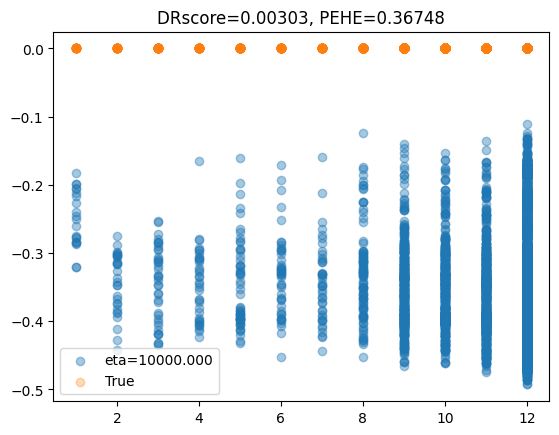

In [52]:
if plot:
    plt.figure(figsize=(20, 5))
    for it, eta in enumerate(eta_grid):
        plt.subplot(1, len(eta_grid), it + 1)
        plt.scatter(X[:, feat_ind], ens[eta][0].predict(X[:, hetero_inds]), label=f'eta={eta:.3f}', alpha=.4)
        plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
        plt.title(f'DRscore={ens[eta][1]:.3f}')
        plt.legend()
    plt.show()

    plt.scatter(X[:, feat_ind], ens[eta_best][0].predict(X[:, hetero_inds]), label=f'eta={eta_best:.3f}', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True', alpha=.3)
    plt.title(f'DRscore={ens[eta_best][1]:.5f}, '
              f'PEHE={pehe(moment_fn(X, true_f), ens[eta_best][0].predict(X[:, hetero_inds])):.5f}')
    plt.legend()
    plt.show()

In [53]:
drscore_best = ens[eta_best]

In [64]:
overall_best = drscore_best[0]

# Interpretation of Learned Model

In [60]:
# explainer = shap.KernelExplainer(overall_best.predict, X[np.random.choice(X.shape[0], 100)][:, hetero_inds])
# shap_values = explainer.shap_values(Xval[:100, hetero_inds], nsamples=100)

In [61]:
# shap.summary_plot(shap_values, feature_names=np.array(column_names)[hetero_inds])

# Validation Based on Calibration

In [56]:
splits_test = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(Xtest, Xtest[:, 0]))

n = Xtest.shape[0]
reg_preds_test = np.zeros(n)
reg_one_preds_test = np.zeros(n)
reg_zero_preds_test = np.zeros(n)

for train, test in splits_test:
    reg_test = model_reg().fit(Xtest[train], ytest[train])
    reg_preds_test[test] = reg_test.predict(Xtest[test])
    reg_one_preds_test[test] = reg_test.predict(np.hstack([np.ones((len(test), 1)), Xtest[test, 1:]]))
    reg_zero_preds_test[test] = reg_test.predict(np.hstack([np.zeros((len(test), 1)), Xtest[test, 1:]]))

prop_preds_test = cross_val_predict(model_t(), Xtest[:, 1:], Xtest[:, 0], cv=splits_test)
res_preds_test = cross_val_predict(model_y(), Xtest[:, 1:], ytest, cv=splits_test)
yres_test = ytest - res_preds_test
tres_test = Xtest[:, 0] - prop_preds_test

In [57]:
dr_test = reg_one_preds_test - reg_zero_preds_test
reisz_test = (Xtest[:, 0] - prop_preds_test) / np.clip(prop_preds_test * (1 - prop_preds_test), .09, np.inf)
dr_test += (ytest - reg_preds_test) * reisz_test

In [65]:
cate_test = overall_best.predict(Xtest[:, hetero_inds])

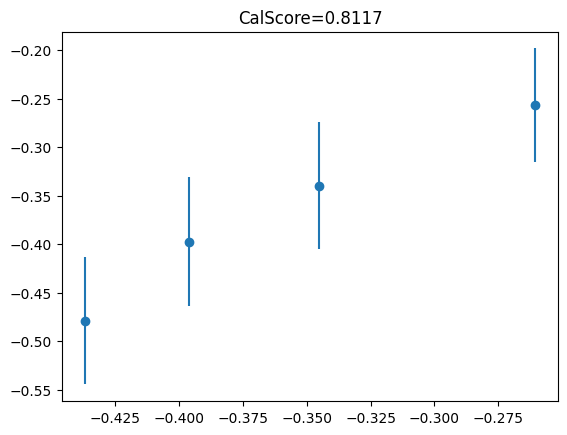

In [66]:
qs = np.percentile(cate_test, np.arange(0, 101, 25))

ate = np.zeros((len(qs) - 1, 3))
predicted_ate = np.zeros(len(qs) - 1)
for it in range(len(qs) - 1):
    inds = (qs[it] <= cate_test) & (cate_test < qs[it + 1])
    ate[it, :] = (np.mean(dr_test[inds]), np.std(dr_test[inds])/np.sqrt(np.sum(inds)), np.mean(inds))
    predicted_ate[it] = np.mean(cate_test[inds])

cal = np.sum(ate[:, 2] * np.abs(ate[:, 0] - predicted_ate))
calbase = np.sum(ate[:, 2] * np.abs(ate[:, 0] - np.mean(dr_test)))
calscore = 1 - cal/calbase
plt.title(f'CalScore={calscore:.4f}')
plt.errorbar(predicted_ate, ate[:, 0], yerr=1.96*ate[:, 1], fmt='o')
plt.show()

# Validation Based on Uplift Curves

#### Uniform Confidence Band with Multiplier Bootstrap

3.7703995728363355


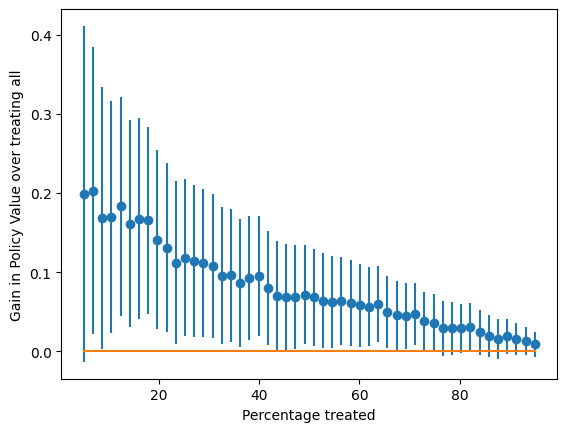

Heterogeneity Statistic: 0.047163562993593075


In [67]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Xval[:, hetero_inds]), ugrid)

ate = np.zeros((len(qs), 3))
true_ate = np.zeros(len(qs))
psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
all_ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test)
    prob = np.sum(inds) / n
    pate = np.mean(dr_test * inds / prob)
    psi[it, :] = (dr_test - all_ate) * (inds / prob - 1)
    ate[it, 0] = np.mean(psi[it])
    psi[it, :] -= ate[it, 0]
    ate[it, 1] = np.sqrt(np.mean(psi[it]**2) / n)
    ate[it, 2] = prob
    if semi_synth:
        true_cate = moment_fn(Xtest, true_f)
        true_ate[it] = np.mean((true_cate - np.mean(true_cate)) * (inds * n / np.sum(inds) - 1))

if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / ate[:, [1]]) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (psi / ate[:, [1]]) @ w / n
max_mboot = np.max(np.abs(mboot), axis=0)
max_percentile = np.percentile(max_mboot, 99)
print(max_percentile)
plt.errorbar(100 - ugrid, ate[:, 0], yerr=max_percentile*ate[:, 1], fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_ate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over treating all")
plt.show()
print(f'Heterogeneity Statistic: {np.max(ate[:, 0] - max_percentile*ate[:, 1])}')

In [68]:
autoc_psi = np.sum(psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(ate[:-1, 0] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(autoc, autoc_stderr, 2.58 * autoc_stderr)

0.07103827393532974 0.012214182683771875 0.031512591324131436


3.4501374724357254


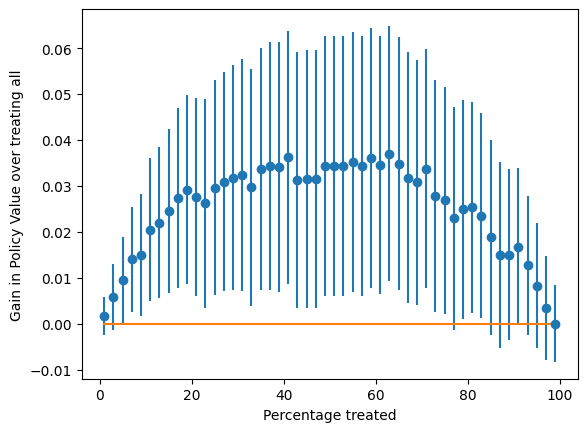

Heterogeneity Statistic: 0.00920183389994475


In [69]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(1, 99, 50)
qs = np.percentile(overall_best.predict(Xval[:, hetero_inds]), ugrid)

ate = np.zeros((len(qs), 3))
true_ate = np.zeros(len(qs))
psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
all_ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test)
    prob = np.mean(inds)
    psi[it, :] = (dr_test - all_ate) * (inds - prob)
    ate[it, 0] = np.mean(psi[it])
    psi[it, :] -= ate[it, 0]
    ate[it, 1] = np.sqrt(np.mean(psi[it]**2) / n)
    ate[it, 2] = prob
    if semi_synth:
        true_cate = moment_fn(Xtest, true_f)
        true_ate[it] = np.mean((true_cate - np.mean(true_cate)) * (inds - prob))

if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / ate[:, [1]]) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 10000))
    mboot = (psi / ate[:, [1]]) @ w / n
max_mboot = np.max(np.abs(mboot), axis=0)
max_percentile = np.percentile(max_mboot, 99)
print(max_percentile)
plt.errorbar(100 - ugrid, ate[:, 0], yerr=max_percentile*ate[:, 1], fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_ate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over treating all")
plt.show()
print(f'Heterogeneity Statistic: {np.max(ate[:, 0] - max_percentile*ate[:, 1])}')

In [70]:
qini_psi = np.sum(psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
qini = np.sum(ate[:-1, 0] * np.diff(ugrid) / 100)
qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
print(qini, qini_stderr, 2.58 * qini_stderr)

0.025222148416254975 0.004629469466921709 0.01194403122465801


# Validation based on p-value of linear heterogeneity model in PLR

In [71]:
OLS(yres_test, np.stack((np.ones(len(tres_test)), tres_test,
                        (cate_test - np.mean(cate_test)) * tres_test), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     281.8
Date:                Tue, 07 Mar 2023   Prob (F-statistic):          2.10e-111
Time:                        10:09:00   Log-Likelihood:                -1325.0
No. Observations:                2582   AIC:                             2656.
Df Residuals:                    2579   BIC:                             2673.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.008     -0.107      0.915      -0.016       0.015
x1            -0.3687      0.016    -23.159      0.000      -0.400      -0.338
x2             1.1544      0.223      5.185      0.000       0.718       1.591
==============================================================================
Omnibus:                      163.397   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.877
Skew:                           0.580   Prob(JB):                     5.80e-37
Kurtosis:                       2.547   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Validation based on p-value of DR out of sample

In [72]:
OLS(dr_test, np.stack((np.ones(len(tres_test)), cate_test - np.mean(cate_test)), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     29.40
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           6.44e-08
Time:                        10:09:02   Log-Likelihood:                -3187.5
No. Observations:                2582   AIC:                             6379.
Df Residuals:                    2580   BIC:                             6391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3682      0.016    -22.490      0.000      -0.400      -0.336
x1             1.2394      0.229      5.422      0.000       0.791       1.688
==============================================================================
Omnibus:                      110.636   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.081
Skew:                           0.415   Prob(JB):                     5.03e-22
Kurtosis:                       2.526   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# hypothetical ideal validation for semi-synthetic data

OLS(moment_fn(Xtest, true_f),
    np.stack((np.ones(len(tres_test)), cate_test - np.mean(cate_test)), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                nan
Time:                        10:09:03   Log-Likelihood:                    inf
No. Observations:                2582   AIC:                              -inf
Df Residuals:                    2580   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        nan           0           0
x1                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Confidence Intervals with the DRLearner

In [74]:
from statsmodels.api import OLS
Xpoly = PolynomialFeatures(degree=1, include_bias=True).fit_transform(X[:, hetero_inds])
lr = OLS(dr_preds, Xpoly).fit()
pred_df = lr.get_prediction(Xpoly).summary_frame(alpha=.01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


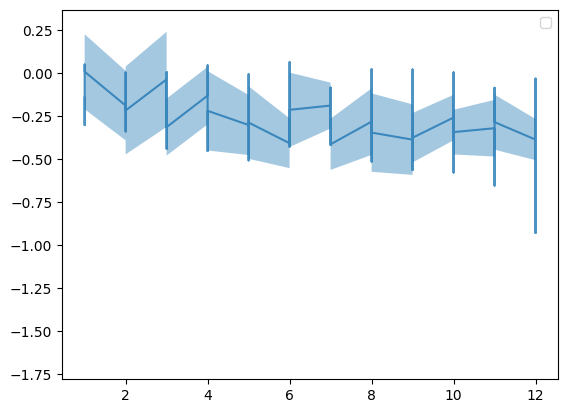

In [75]:
inds = np.argsort(X[:, feat_ind])
plt.fill_between(X[inds, feat_ind], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.plot(X[inds, feat_ind], pred_df['mean'][inds], alpha=.8)
plt.legend()
plt.show()

In [ ]:
if semi_synth:
    inds = np.argsort(X[:, feat_ind])
    true_proj = LinearRegression().fit(Xpoly, moment_fn(X, true_f)).predict(Xpoly)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], pred_df['mean'][inds])
    plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.legend()
    plt.show()

In [77]:
from statsmodels.formula.api import ols
df = pd.DataFrame(X[:, hetero_inds], columns=np.array(column_names)[hetero_inds])
df['dr'] = dr_preds
lr = ols('dr ~ C(polviews)', df).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     8.049
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           1.10e-08
Time:                        10:09:23   Log-Likelihood:                -9496.0
No. Observations:                7744   AIC:                         1.901e+04
Df Residuals:                    7737   BIC:                         1.905e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1888      0.056     -3.364      0.001      -0.299      -0.079
C(polviews)[T.2.0]    -0.0643      0.062     -1.032      0.302      -0.186       0.058
C(polviews)[T.3.0]    -0.1066      0.062     -1.733      0.083      -0.227       0.014
C(polviews)[T.4.0]    -0.1933      0.058     -3.318      0.001      -0.307      -0.079
C(polviews)[T.5.0]    -0.2443      0.061     -4.037      0.000      -0.363      -0.126
C(polviews)[T.6.0]    -0.2050      0.061     -3.349      0.001      -0.325      -0.085
C(polviews)[T.7.0]    -0.2551      0.079     -3.239      0.001      -0.410      -0.101
==============================================================================
Omnibus:                      495.382   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.065
Skew:                           0.372   Prob(JB):                     1.41e-69
Kurtosis:                       2.345   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
pred_df = lr.get_prediction(df).summary_frame(alpha=.01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


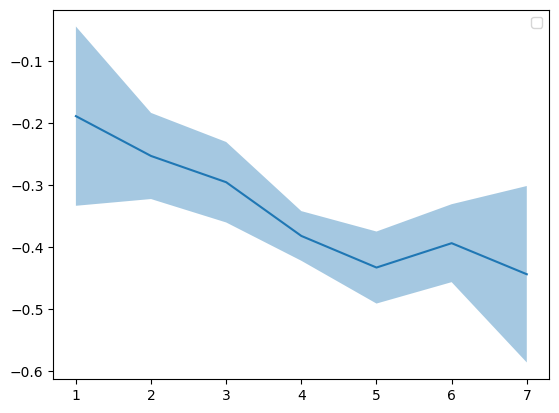

In [79]:
inds = np.argsort(df['polviews']) #X[:, feat_ind])
plt.plot(df['polviews'].iloc[inds], pred_df['mean'][inds])
plt.fill_between(df['polviews'].iloc[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.legend()
plt.show()

In [ ]:
if semi_synth:
    true_proj = LinearRegression().fit(np.log(df[['inc']]), moment_fn(X, true_f)).predict(np.log(df[['inc']]))
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], pred_df['mean'][inds])
    plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.legend()
    plt.show()

# Non-Parametric Confidence Intervals with Causal Forests

In [82]:
from econml.grf import CausalForest

est = CausalForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50, min_weight_fraction_leaf=.0)
est.fit(X[:, hetero_inds], tres, yres)

CausalForest(max_depth=5, max_samples=0.4, min_samples_leaf=50,
             n_estimators=4000)

In [83]:
top_feat = hetero_inds[np.argsort(est.feature_importances_)[-1]]
print(column_names[top_feat])

polviews


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


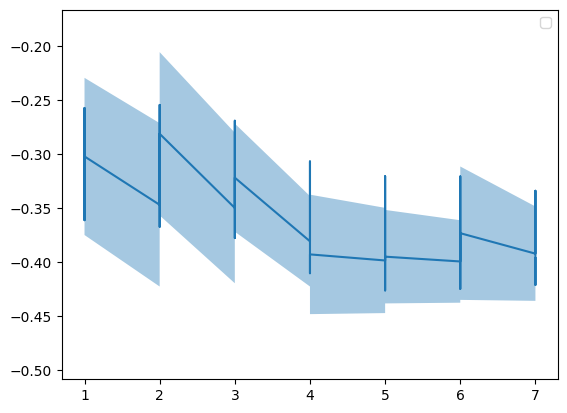

In [84]:
inds = np.argsort(df['polviews']) #X[:, feat_ind])
preds, lb, ub = est.predict(X[:, hetero_inds], interval=True, alpha=.01)
plt.plot(df['polviews'].iloc[inds], preds[inds])
plt.fill_between(df['polviews'].iloc[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.legend()
plt.show()

In [85]:
if semi_synth:
    true_proj = moment_fn(X, true_f)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.legend()
    plt.show()

In [86]:
from econml.dml import CausalForestDML

est = CausalForestDML(model_y=model_y(), model_t=model_t(),
                      n_estimators=4000, cv=5)

In [87]:
est.tune(y, X[:, 0], X=X[:, 1:])

In [88]:
est.fit(y, X[:, 0], X=X[:, 1:])

In [89]:
df = pd.DataFrame(X[:, 1:], columns=np.array(column_names)[1:])
grid = np.unique(np.percentile(df['polviews'], np.arange(0, 110, 20)))
dfpd = pd.DataFrame(np.tile(np.median(df, axis=0, keepdims=True), (len(grid), 1)),
                    columns=df.columns)
dfpd['polviews'] = grid

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


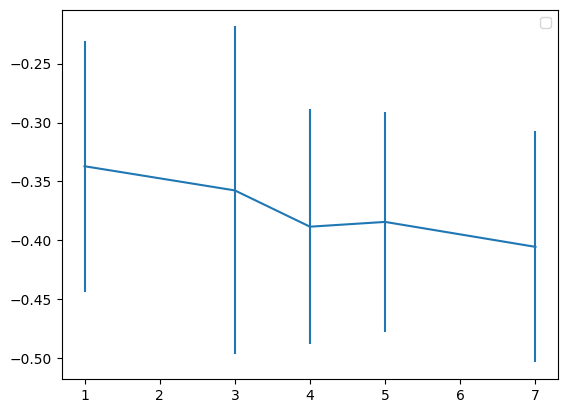

In [90]:
inf = est.effect_inference(dfpd)
preds, lb, ub = inf.pred, *inf.conf_int(alpha=0.01)
plt.errorbar(dfpd['polviews'], preds, yerr=(preds-lb, ub-preds))
plt.legend()
plt.show()

# Non-Parametric Confidence Intervals with Doubly Robust Forests

In [91]:
from econml.grf import RegressionForest

est = RegressionForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50,
                       min_weight_fraction_leaf=.0, n_jobs=1, verbose=3)
est.fit(X[:, hetero_inds], dr_preds)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:  1.0min finished


RegressionForest(max_depth=5, max_samples=0.4, min_samples_leaf=50,
                 n_estimators=4000, n_jobs=1, verbose=3)

In [92]:
top_feat = hetero_inds[np.argsort(est.feature_importances_)[-1]]
print(column_names[top_feat])

polviews


In [97]:
lb.shape

(5, 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.8s finished
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


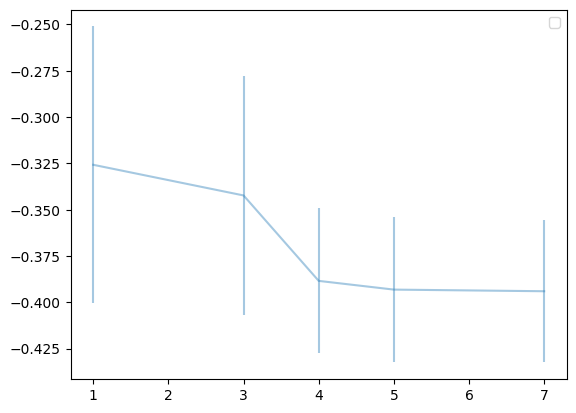

In [98]:
df = pd.DataFrame(X[:, 1:], columns=np.array(column_names)[1:])
grid = np.unique(np.percentile(df[column_names[top_feat]], np.arange(0, 110, 20)))
dfpd = pd.DataFrame(np.tile(np.median(df, axis=0, keepdims=True), (len(grid), 1)),
                    columns=df.columns)
dfpd['polviews'] = grid

preds, lb, ub = est.predict(dfpd, interval=True, alpha=.01)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(dfpd['polviews'], preds, yerr=(preds-lb, ub-preds), alpha=.4)
plt.legend()
plt.show()

In [ ]:
if semi_synth:
    true_proj = moment_fn(Xs, true_f)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.legend()
    plt.show()